# Jupyter Notebook per localizzare un evento sismico via McMC

### TASK:

Localizzare un evento sismico attraverso i tempi di arrivo delle onde P e S in un semispazio omogeneo utilizzando il metodo "Markov chain Monte Carlo"

### WORKFLOW:


### Import libraries

In [1]:
# Per la gestione dei file
import os

# Per il calcolo numerico
import numpy as np
from math import sqrt

# Per la presentazione grafica dei risultati
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec



# Per le parti interattive del Notebook
from ipywidgets import interact, Layout
import ipywidgets as widgets

#Per visualizzare immagini
from IPython.display import Image
import matplotlib.image as image 


#Per McMC sampling
from mcmc_locate_exp_cov import npa_candidate_model
from mcmc_locate_exp_cov import npa_log_likelihood
from mcmc_locate_exp_cov import npa_LOCATE_syn
from mcmc_locate_exp_cov import npa_metropolis
from mcmc_locate_exp_cov import npa_get_starting_model



### Definizioni

In [2]:
#
##############################################################################
#
# EDIT HERE ---- Variabili utilizzate nel Notebook per l'analisi
#
#
#Evento sismico
EVENT_NAME="HAMMER_01"                   # LABEL per i file creati
event_X=15.5                           # Approx longitudine dell' evento
event_Y=6.5                           # Approx latitudine dell' evento
event_stat_plot="img/geometry_16_05_final.png"      # Mappa dati utilizzati
#
#
##############################################################################
#
    
# Fasi sismiche
datafile="input/HAMMER_01.dat"  # File contenente le informazioni sulle stazioni sismiche utilizzate

print(' Selected event: ' + EVENT_NAME)

 Selected event: HAMMER_01


### Mappa delle stazioni sismiche selezionate e dell evento

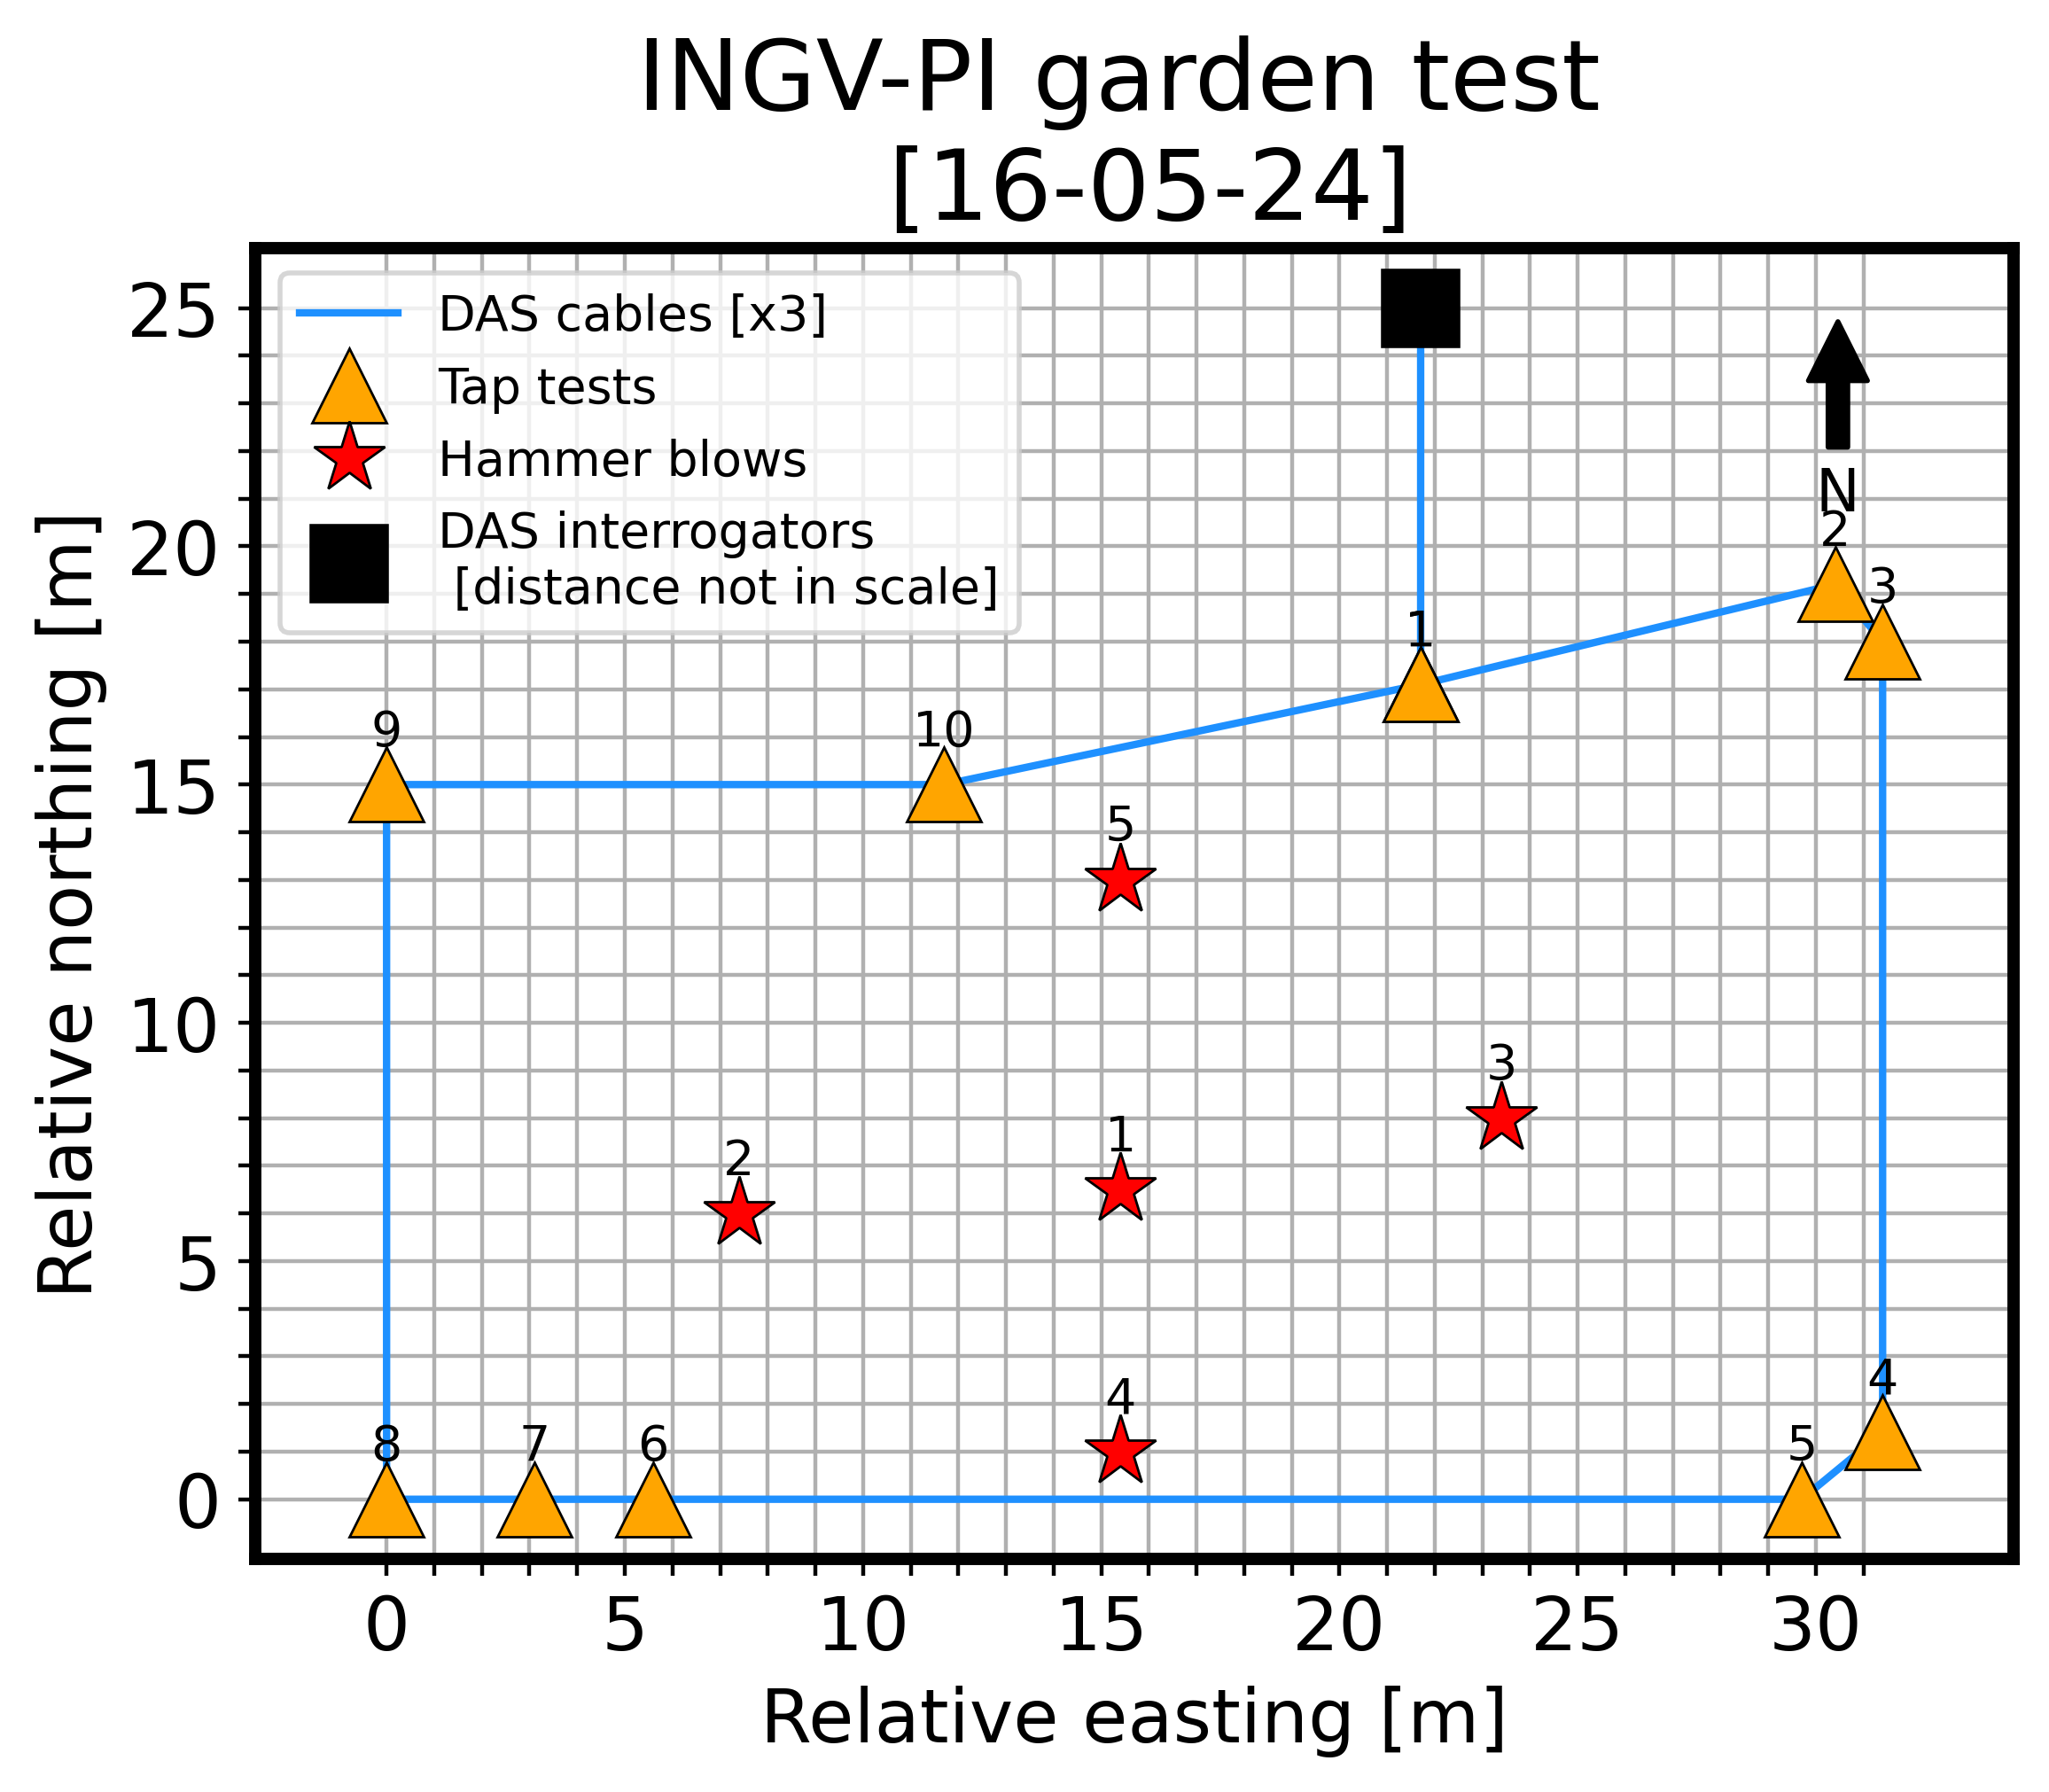

In [3]:
Image(event_stat_plot,width=2000)

## (1) Leggere i dati relativi all' evento (i.e. i tempi di arrivo delle onde P)

In [4]:
    

statfile = open(datafile, 'r')

stlo, stla, Ppick = np.loadtxt(datafile, dtype=float, usecols=(3,4,2), unpack=True)

nstat_sele=len(stlo)
min_P_pick = float(min(Ppick))
print('Found', nstat_sele, 'stations with associated picking -- earliest P-arrival:', min_P_pick)

Found 137 stations with associated picking -- earliest P-arrival: 0.0


## (2) Utilizzare i tempi di arrivo per localizzare l' evento sismico

In questo caso, utilizzeremo una semplice catena di Markov per localizzare l' evento. L' algoritmo, partendo da un modello casuale, cerchera'. di trovare le possibili localizzazioni che spiegano i dati osservati. Per fare cio', applicheremo la regola di Metropolis. 

### Monte Carlo sampling using Metropolis' rule (i.e. Markov chain Monte Carlo, or McMC)

(0) Define an initial model as a random realization fo the prior information

  (0.1) Compute predicted data given by the initial model

  (0.2) Compute the Likelihood between observed data and predicted data
  
#### Start McMC: sampling the model-space 
    
(1) Sampling of the model-space (repeated N times)

  (1.1) Propose a candidate model as a small preturbation of the current model
  
  (1.2) Compute predicted data given by the candidate model

  (1.3) Compute the Likelihood between observed data and predicted data

  (1.4) Apply Metropolis'rule to select between candidate and current model

  (1.5) (after burn-in phase) Store the selected model for post-processing
  
### Post processing for evaluate statisical estimators (e.g. mean value of the investigated parameters)

(2.1) Compute posterior mean and standard deviation of the investigated parameters

(2.2) Plot results


    


In [21]:
#######################################################
#######################################################
#
# EDIT HERE
#
# Define the model space
# (Uniform prior probability distirbution)
#
xmin=-5       # in m
xmax=35       # in m
ymin=-5       # in m
ymax=25       # in m
zmin=-10      # in m
zmax=0        # in m
tmin=-0.1     # in s
tmax=0.1      # in s
vpmin=500.0   # in m/s
vpmax=3000.0  # in m/s

# FOR CREATING SYNTHETICS
# xmin=15       # in m
# xmax=15       # in m
# ymin=5        # in m
# ymax=5        # in m
# zmin=0        # in m
# zmax=0        # in m
# tmin=-0.001   # in s
# tmax=-0.001   # in s
# vpmin=600.0   # in m/s
# vpmax=600.0   # in m/s
#
#
#   MARKOV CHAIN MONTE CARLO PARAMETERS
# 
N_CHAINS=10                        # Number of chains
N_MOD_MCMC=20000                   # Number of samples collected alon the McMC
BURN_IN=10000                       # Samples discarded at the beginning of the McMC
PRIOR = 0                          # PRIOR SAMPLING: 1- sampling prior information; 0- Monte Carlo sampling 
#
#
#   EXPONENTIAL COVARIANCE MATRIX DEFINITIONS
#
std0=0.001
r_corr=0.9
#
#
# RANDOM SEED -- to produce always the same sequence of pseudo-random numbers
#
rseed=210728
rng = np.random.default_rng(rseed)
#
#######################################################
#######################################################
#######################################################


#######################################################
#######################################################
#######################################################

#
# Pre-compute inverse of EXP cov matrix
#

cor = np.zeros((nstat_sele,nstat_sele), dtype=float)
icov = np.zeros((nstat_sele,nstat_sele), dtype=float)

ir=0
while ir < nstat_sele:
    
    if ir == 0:
        diag0=1.0+(r_corr**2)
    if ir == 1:
        diag0=-1.0*r_corr
    if ir > 1:
        diag0=0.0

    ic=ir
    while ic < nstat_sele-1:
    
        cor[ic-ir,ic]=diag0
        cor[ic,ic-ir]=diag0
    
        ic+=1
        
    ir+=1


cor[0,0]=1.0
cor[nstat_sele-1,nstat_sele-1]=1.0

ir=0
ic=0
while ir < nstat_sele:
    ic=0
    while ic < nstat_sele:
        icov[ir,ic]=(1.0/(1.0-(r_corr**2)))*(1.0/(std0*std0))*cor[ir,ic]
        ic += 1
    ir += 1
    
print('\n PRE-PROCESSING of the INVERSE COV MATRIX: \n')
print(cor,icov)
print('\n INVERSE of an EXPONENTIAL COV MATRIX should be tri-diagonal \n')

#######################################################
#######################################################
#######################################################


#
# Initialize vectors for collecting sampled models
#
ALL_X = []
ALL_Y = []
ALL_Z = []
ALL_T = []
ALL_VP = []

#
#
# (1) Campionamento dello spazio dei parametri (ripetuto N volte per M catene di Markov diverse)
#
ichain = 1 
while ichain <= N_CHAINS:
    
    #
    # (2) DEFINE STARTING MODEL as a random point in the model-space
    #
    X0, Y0, Z0, T0, VP0 = npa_get_starting_model(rng, xmin, xmax, ymin, ymax, zmin, zmax, tmin, tmax, vpmin, vpmax)
    #
    print('\n%s\n%s%8.2f%s%8.2f%s%8.2f%s%8.2f%s%8.2f\n' % ("STARTING MODEL:",  " - X: ", X0, " - Y: ", Y0, " - Z: ", Z0, " - T0: ", T0, " - Vp: ", VP0)) 
    #
    # (3.1) COMPUTE SYNTHETICS for starting model
    #
    SYN_data_P = []
    SYN_data_P = npa_LOCATE_syn(nstat_sele, stlo, stla, X0, Y0, Z0, T0, VP0)
    #
    # Write out last synthetics -- for a synthetic test
    #
    if N_MOD_MCMC == 1 and ichain == 1:
        istat=0
        while istat < nstat_sele:
            x1=stlo[istat]
            y1=stla[istat]
            #theo_P=SYN_data_P[istat]   # SYNTHETICS without noise
            theo_P=SYN_data_P[istat]+rng.normal(0.0,std0)  # SYNTHETICS with ADDED noise
            print("%8d%8d%10.6f%10.1f%10.1f" % (istat,istat,theo_P,x1,y1))
            istat += 1

    #
    # (3.2) COMPUTE FIT TO STARTING MODEL
    #
    lppd0 = npa_log_likelihood(nstat_sele, SYN_data_P, Ppick, icov)
    #
    #
    print('\n LOG LIKELIHOOD starting model: ', lppd0)
    #
    #
    #
    #
    #
    #
    #    START MCMC
    #
    #

    imod = 1
    while imod <= N_MOD_MCMC:
    #
    #


    #
    #
    #
    # (4.1) Propose a candidate model as a small preturbation of the current model
    #
    #
        X_cand, Y_cand, Z_cand, T_cand, VP_cand = npa_candidate_model(rng, X0, Y0, Z0, T0, VP0, xmin, xmax, ymin, ymax, zmin, zmax, tmin, tmax, vpmin, vpmax)
    #
    #

        #print("%s%10.3f%10.3f%10.3f" % ('\n   CURRENT MODEL: ', X0, Y0, Z0))
        #print("%s%10.3f%10.3f%10.3f" % (' CANDIDATE MODEL: ', X_cand, Y_cand, Z_cand))

    #
    #
    #  (4.2) Compute predicted data given by the candidate model
    #
    #
        SYN_data_P = []
        SYN_data_P = npa_LOCATE_syn(nstat_sele, stlo, stla, X_cand, Y_cand, Z_cand, T_cand, VP_cand)
    #
    #

    #
    #
    # (4.3) Compute the Likelihood between observed data and predicted data
    #
    #
        lppd = npa_log_likelihood(nstat_sele, SYN_data_P, Ppick,  icov)

        if PRIOR == 1:
            lppd0 = 1.0
            lppd  = 1.0
   
    #
    #
    # (4.4) Apply Metropolis'rule to select between candidate and current model
    #
    #
        Accepted = npa_metropolis(rng, lppd,lppd0)
    #
    #
        if imod % 1000 == 0:
            print("%s%4d%s%9d%s%4d%s%16.2f%16.2f" % ('CHAIN: ', ichain, ' SAMPLED MODEL: ', imod, '  Accepted:', Accepted, '  LPPD: ', lppd, lppd0))



    #
    #
    # (4.5) Store the selected model for post-processing
    #
    #
    # If the candidate model is rejected, current model becomes candidate model
    #
        if Accepted == 0:
            
            X_cand = X0
            Y_cand = Y0
            Z_cand = Z0
            T_cand = T0
            VP_cand = VP0
            lppd = lppd0

    #
    # Store candidate model (after BURN-IN phase)
    #

        if imod >= BURN_IN:
            
            if imod % 100 == 0:
            
                ALL_X.append(X_cand)
                ALL_Y.append(Y_cand)
                ALL_Z.append(Z_cand)
                ALL_VP.append(VP_cand)
                ALL_T.append(T_cand)

    #
    # Candidate model becomes current model
    #

        X0 = X_cand
        Y0 = Y_cand
        Z0 = Z_cand
        T0 = T_cand
        VP0 = VP_cand
        lppd0 = lppd


    # Move McMC chain
        imod += 1
    
    
    
    

# Run a new indipendent McMC sampling
    ichain += 1



 PRE-PROCESSING of the INVERSE COV MATRIX: 

[[ 1.   -0.9   0.   ...  0.    0.    0.  ]
 [-0.9   1.81 -0.9  ...  0.    0.    0.  ]
 [ 0.   -0.9   1.81 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.81 -0.9   0.  ]
 [ 0.    0.    0.   ... -0.9   1.81  0.  ]
 [ 0.    0.    0.   ...  0.    0.    1.  ]] [[ 5263157.89473684 -4736842.10526316        0.         ...
         0.                0.                0.        ]
 [-4736842.10526316  9526315.78947369 -4736842.10526316 ...
         0.                0.                0.        ]
 [       0.         -4736842.10526316  9526315.78947369 ...
         0.                0.                0.        ]
 ...
 [       0.                0.                0.         ...
   9526315.78947369 -4736842.10526316        0.        ]
 [       0.                0.                0.         ...
  -4736842.10526316  9526315.78947369        0.        ]
 [       0.                0.                0.         ...
         0.                0.          5

CHAIN:    4 SAMPLED MODEL:     13000  Accepted:   0  LPPD:          1244.27          202.01
CHAIN:    4 SAMPLED MODEL:     14000  Accepted:   0  LPPD:           218.86          201.51
CHAIN:    4 SAMPLED MODEL:     15000  Accepted:   0  LPPD:           517.73          215.18
CHAIN:    4 SAMPLED MODEL:     16000  Accepted:   0  LPPD:           563.30          200.57
CHAIN:    4 SAMPLED MODEL:     17000  Accepted:  -1  LPPD:           201.18          201.11
CHAIN:    4 SAMPLED MODEL:     18000  Accepted:  -1  LPPD:           203.93          202.57
CHAIN:    4 SAMPLED MODEL:     19000  Accepted:  -1  LPPD:           206.85          205.41
CHAIN:    4 SAMPLED MODEL:     20000  Accepted:   0  LPPD:           274.49          204.96

STARTING MODEL:
 - X:     6.60 - Y:    19.98 - Z:    -8.97 - T0:    -0.01 - Vp:  2270.34


 LOG LIKELIHOOD starting model:  6188.843769503139
CHAIN:    5 SAMPLED MODEL:      1000  Accepted:   0  LPPD:           274.28          272.33
CHAIN:    5 SAMPLED MODEL:   

CHAIN:    8 SAMPLED MODEL:     16000  Accepted:  -1  LPPD:           208.37          208.29
CHAIN:    8 SAMPLED MODEL:     17000  Accepted:   0  LPPD:           227.86          201.39
CHAIN:    8 SAMPLED MODEL:     18000  Accepted:   0  LPPD:          1608.63          203.80
CHAIN:    8 SAMPLED MODEL:     19000  Accepted:   0  LPPD:           249.81          204.38
CHAIN:    8 SAMPLED MODEL:     20000  Accepted:   0  LPPD:           215.99          204.49

STARTING MODEL:
 - X:    19.31 - Y:    13.69 - Z:    -9.10 - T0:    -0.04 - Vp:  1559.58


 LOG LIKELIHOOD starting model:  30622.46910609665
CHAIN:    9 SAMPLED MODEL:      1000  Accepted:   0  LPPD:           268.86          232.98
CHAIN:    9 SAMPLED MODEL:      2000  Accepted:   0  LPPD:           266.40          214.55
CHAIN:    9 SAMPLED MODEL:      3000  Accepted:   0  LPPD:           532.22          207.67
CHAIN:    9 SAMPLED MODEL:      4000  Accepted:   0  LPPD:           234.33          207.95
CHAIN:    9 SAMPLED MODEL:   

## Post-processing: compute posterior mean values of the investigated parameters 

In [22]:
AVER_X = np.mean(ALL_X,axis=0)
STD_X = np.std(ALL_X,axis=0)

AVER_Y = np.mean(ALL_Y,axis=0)
STD_Y = np.std(ALL_Y,axis=0)

AVER_Z = np.mean(ALL_Z,axis=0)
STD_Z = np.std(ALL_Z,axis=0)

AVER_T = np.mean(ALL_T,axis=0)
STD_T = np.std(ALL_T,axis=0)

AVER_VP = np.mean(ALL_VP,axis=0)
STD_VP = np.std(ALL_VP,axis=0)


print('\n MEAN PPD  and STD PPD: \n')
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('X: ', AVER_X, STD_X, ' PRIOR MEAN/STD: ', 0.5*(xmin+xmax), (xmax-xmin)/sqrt(12)) )
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('Y: ', AVER_Y, STD_Y, ' PRIOR MEAN/STD: ', 0.5*(ymin+ymax), (ymax-ymin)/sqrt(12)) )
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('Z: ', AVER_Z, STD_Z, ' PRIOR MEAN/STD: ', 0.5*(zmin+zmax), (zmax-zmin)/sqrt(12)) )
print('%20s%10.4f%10.4f%25s%10.4f%10.4f' % ('T: ', AVER_T, STD_T, ' PRIOR MEAN/STD: ', 0.5*(tmin+tmax), (tmax-tmin)/sqrt(12)) )
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('Vp: ', AVER_VP, STD_VP, ' PRIOR MEAN/STD: ', 0.5*(vpmin+vpmax), (vpmax-vpmin)/sqrt(12)) )




 MEAN PPD  and STD PPD: 

                 X:      14.89    0.2148         PRIOR MEAN/STD:      15.00   11.5470
                 Y:       6.26    0.1649         PRIOR MEAN/STD:      10.00    8.6603
                 Z:      -1.17    0.8573         PRIOR MEAN/STD:      -5.00    2.8868
                 T:    -0.0090    0.0006         PRIOR MEAN/STD:     0.0000    0.0577
                Vp:     515.34   12.0415         PRIOR MEAN/STD:    1750.00  721.6878


## Post-processing: 1D PPD  of the investigated parameters 

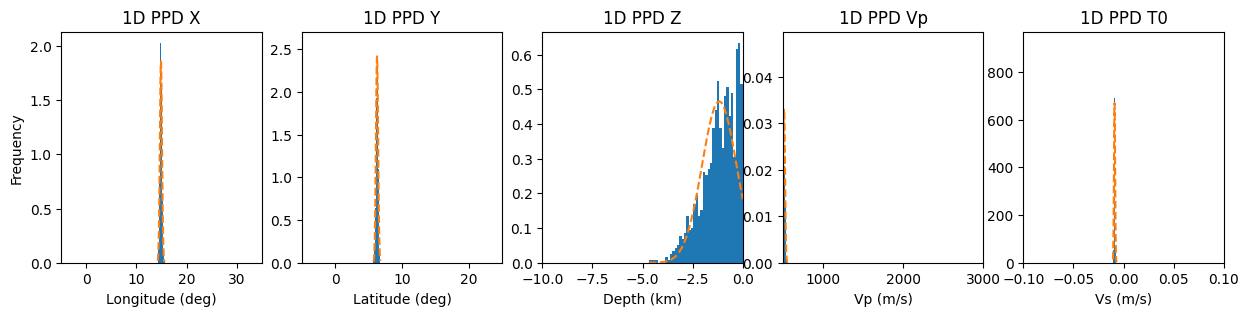

In [23]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.title.set_text('1D PPD X' )
mu = AVER_X
sigma = STD_X
n, bins, patches = ax1.hist(ALL_X, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax1.plot(bins,y,'--')
ax1.set_xlim(xmin, xmax)
ax1.set_xlabel('Longitude (deg)')
ax1.set_ylabel('Frequency')

ax2.title.set_text('1D PPD Y' )
mu = AVER_Y
sigma = STD_Y
n, bins, patches = ax2.hist(ALL_Y, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax2.plot(bins,y,'--')
ax2.set_xlim(ymin, ymax)
ax2.set_xlabel('Latitude (deg)')

ax3.title.set_text('1D PPD Z' )
mu = AVER_Z
sigma = STD_Z
n, bins, patches = ax3.hist(ALL_Z, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax3.plot(bins,y,'--')
ax3.set_xlim(zmin,zmax)
ax3.set_xlabel('Depth (km)')

ax4.title.set_text('1D PPD Vp' )
mu = AVER_VP
sigma = STD_VP
n, bins, patches = ax4.hist(ALL_VP, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax4.plot(bins,y,'--')
ax4.set_xlim(vpmin,vpmax)
ax4.set_xlabel('Vp (m/s)')

ax5.title.set_text('1D PPD T0' )
mu = AVER_T
sigma = STD_T
n, bins, patches = ax5.hist(ALL_T, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax5.plot(bins,y,'--')
ax5.set_xlim(tmin,tmax)
ax5.set_xlabel('Vs (m/s)')


plt.show()


## Post-processing: 2D PPD  of the investigated parameters 

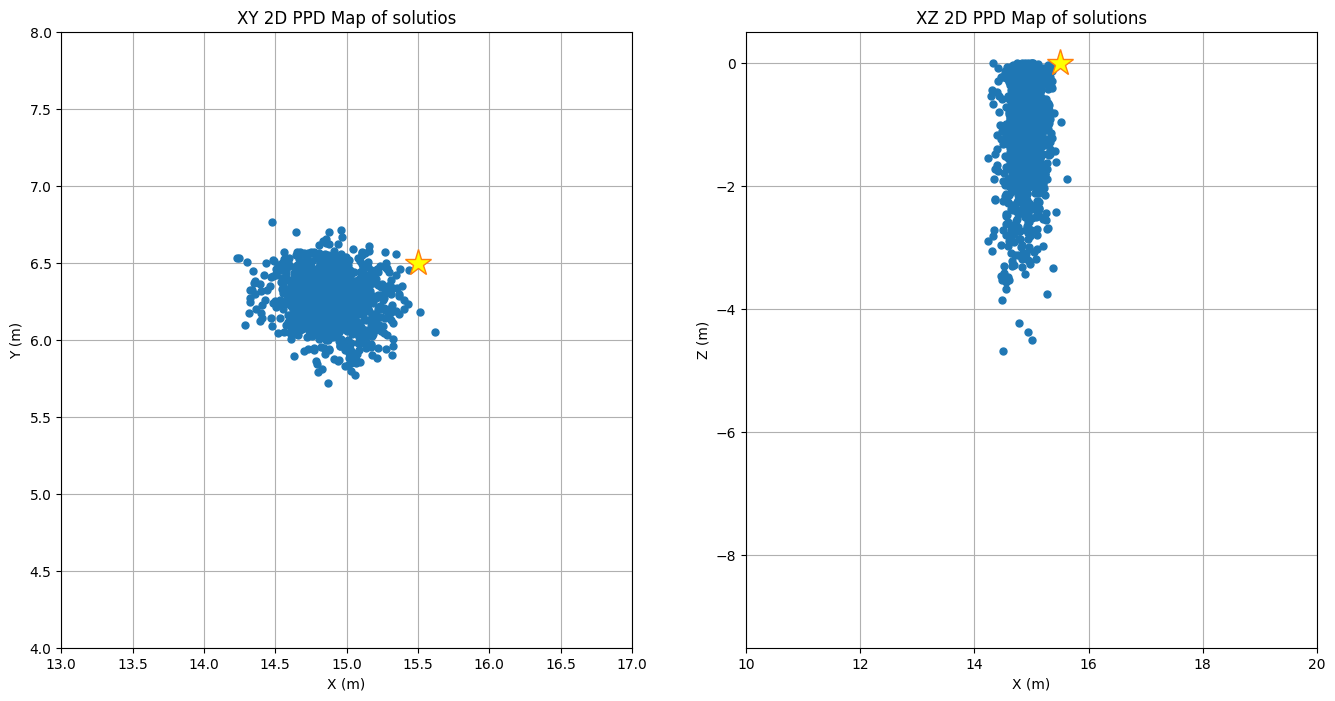

In [24]:

  
fig = plt.figure(figsize=(16.2,8))
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.2, width_ratios=[1,1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.title.set_text('XY 2D PPD Map of solutios' )
ax1.plot(ALL_X, ALL_Y, '.', markersize=10)
ax1.set_xlim(13,17)
ax1.set_ylim(4,8)
ax1.grid()
ax1.plot(event_X, event_Y,marker='*', markersize=20, markerfacecolor='yellow')
ax1.set_ylabel('Y (m)')
ax1.set_xlabel('X (m)')


ax2 = fig.add_subplot(gs[0, 1])
ax2.title.set_text('XZ 2D PPD Map of solutions' )
ax2.plot(ALL_X, ALL_Z, '.', markersize=10)
ax2.set_xlim(10,20)
ax2.set_ylim(-9.5,0.5)
ax2.grid()
ax2.plot(event_X, 0.0,marker='*', markersize=20, markerfacecolor='yellow')
ax2.set_ylabel('Z (m)')
ax2.set_xlabel('X (m)')


outputFigure="MCMC_results.jpg"
plt.savefig(outputFigure)
plt.show()

In [ ]:
%load_ext watermark
%watermark -v -p numpy,matplotlib,obspy,ipywidgets